# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean 

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv("data/train_data.csv")
valid_data = pd.read_csv("data/valid_data.csv")

In [3]:
print(train_data.shape)
train_data.head()

(578, 2)


,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2


In [4]:
print(valid_data.shape)
valid_data.head()

(184, 2)


,Date,count
0,2014-03-26,198
1,2014-03-27,120
2,2014-03-28,207
3,2014-03-29,145
4,2014-03-30,130


# Required Preprocessing 

In [5]:
train_data.timestamp = pd.to_datetime(train_data['Date'],format='%Y-%m-%d')
train_data.index = train_data.timestamp

In [6]:
valid_data.timestamp = pd.to_datetime(valid_data['Date'],format='%Y-%m-%d')
valid_data.index = valid_data.timestamp

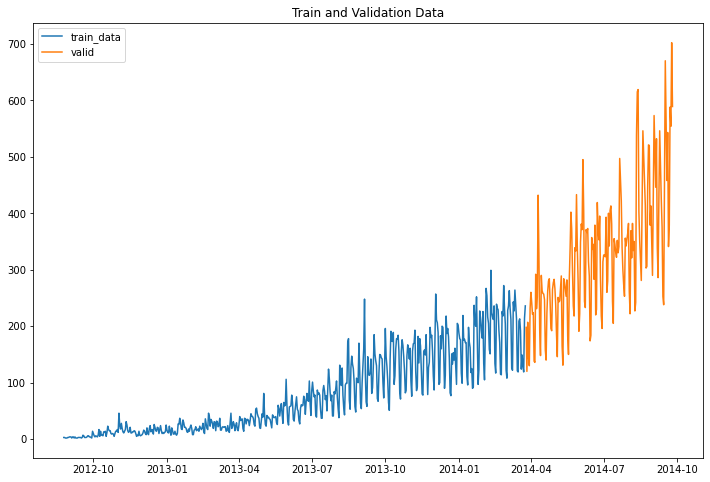

In [7]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['count'], label='train_data')
plt.plot(valid_data.index,valid_data['count'], label='valid')
plt.legend(loc='best')
plt.title("Train and Validation Data")
plt.show()

# Stationarity Test

In [8]:
# dickey fuller, KPSS
from statsmodels.tsa.stattools import adfuller, kpss

In [9]:
def adf_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [10]:
adf_test(train_data['count'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.056611
p-value                          0.953592
#Lags Used                      19.000000
Number of Observations Used    558.000000
Critical Value (1%)             -3.442124
Critical Value (5%)             -2.866734
Critical Value (10%)            -2.569536
dtype: float64


 If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary). **Here test statistic is > than critical. Hence series is not stationary**

In [11]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [12]:
kpss_test(train_data['count'])

Results of KPSS Test:
Test Statistic            2.84663
p-value                   0.01000
Lags Used                19.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary).  **Here test statistic is > than critical. Hence series is not stationary**

Alternatively, we can use the p-value to make the inference. If p-value is less than 0.05, we can reject the null hypothesis. And say that the series is not stationary.

# Making Series Stationary

In [13]:
train_data['count_diff'] = train_data['count'] - train_data['count'].shift(1)

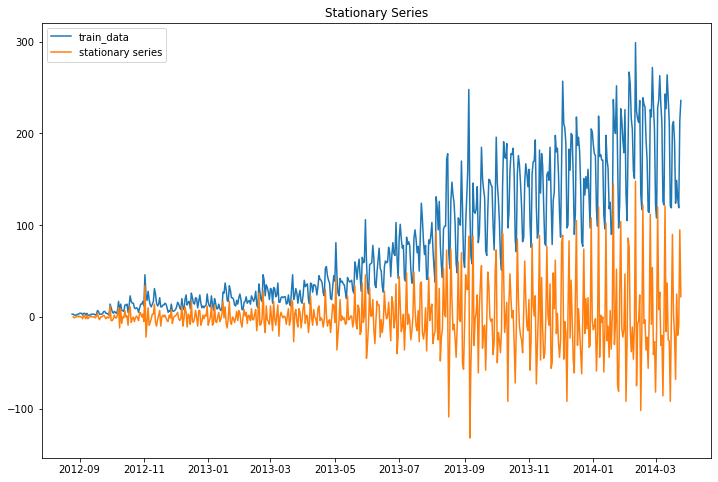

In [14]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['count'], label='train_data')
plt.plot(train_data.index,train_data['count_diff'], label='stationary series')
plt.legend(loc='best')
plt.title("Stationary Series")
plt.show()

In [15]:
train_data['count_log'] = np.log(train_data['count'])
train_data['count_log_diff'] = train_data['count_log'] - train_data['count_log'].shift(1)

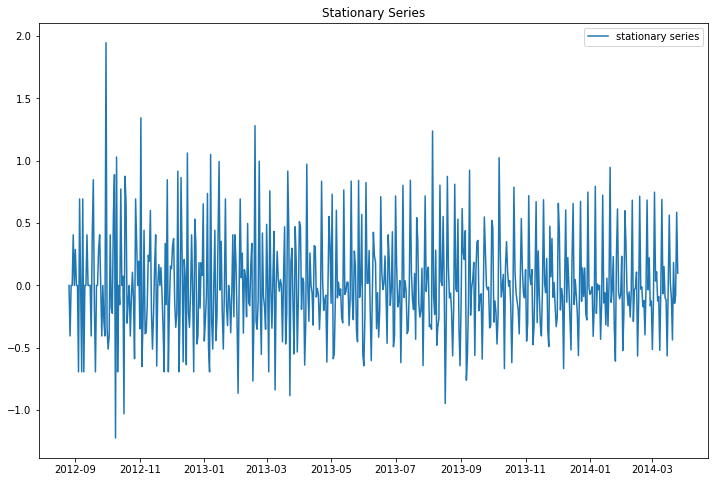

In [16]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index,train_data['count_log_diff'], label='stationary series')
plt.legend(loc='best')
plt.title("Stationary Series")
plt.show()

In [17]:
adf_test(train_data['count_log_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -7.500565e+00
p-value                        4.264600e-11
#Lags Used                     1.900000e+01
Number of Observations Used    5.570000e+02
Critical Value (1%)           -3.442145e+00
Critical Value (5%)           -2.866743e+00
Critical Value (10%)          -2.569541e+00
dtype: float64


In [18]:
kpss_test(train_data['count_log_diff'].dropna())

Results of KPSS Test:
Test Statistic            0.056326
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# ACF and PACF plots

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

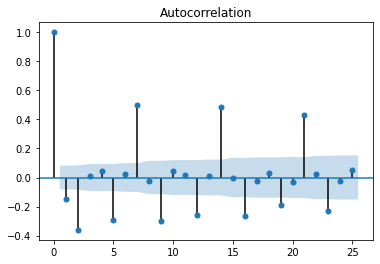

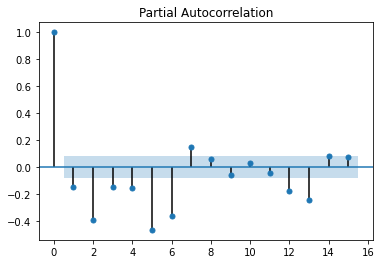

In [20]:
plot_acf(train_data['count_log_diff'].dropna(), lags=25)
plot_pacf(train_data['count_log_diff'].dropna(), lags=15)
plt.show()

   - p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=2.

   - q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=2.

   - Now we will make the ARIMA model as we have the p,q values.

# AR model

In [21]:
from statsmodels.tsa.arima_model import ARIMA

In [22]:
# fit AR model
model = ARIMA(train_data['count_log'], order=(2,1,0))
model_fit = model.fit()

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [23]:
output = model_fit.forecast(184)
valid_data['AR'] = (pd.DataFrame(output[0])).values

In [24]:
valid_data['AR'] = np.exp(valid_data['AR'])

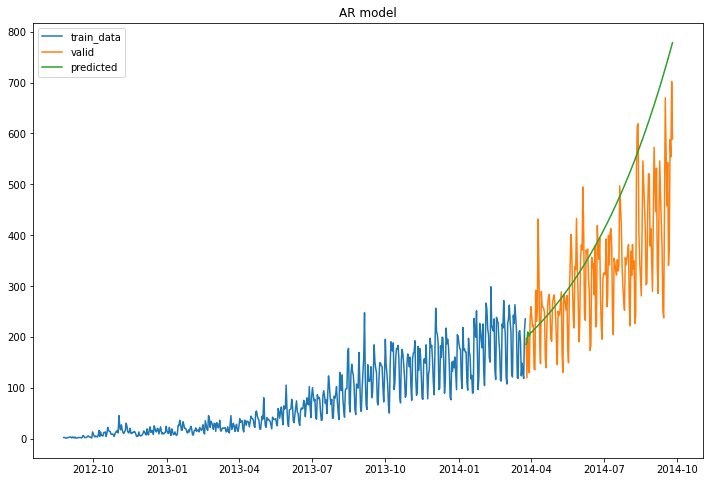

In [25]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['count'], label='train_data')
plt.plot(valid_data.index, valid_data['count'], label='valid')
plt.plot(valid_data.index, valid_data['AR'], label='predicted')

plt.legend(loc='best')
plt.title("AR model")
plt.show()

In [26]:
# calculating RMSE 
rmse = sqrt(mean_squared_error(valid_data['count'], valid_data['AR']))
print('The RMSE value for AR is', rmse)

The RMSE value for AR is 155.26688313154048


# MA model

In [27]:
# fit MA model
model = ARIMA(train_data['count_log'], order=(0,1,2))
model_fit = model.fit()

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [28]:
output = model_fit.forecast(184)
valid_data['MA'] = (pd.DataFrame(output[0])).values

In [29]:
valid_data['MA'] = np.exp(valid_data['MA'])

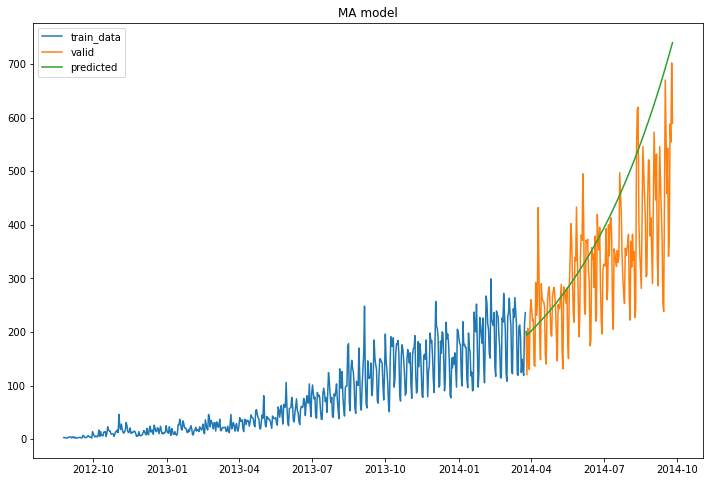

In [30]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['count'], label='train_data')
plt.plot(valid_data.index, valid_data['count'], label='valid')
plt.plot(valid_data.index, valid_data['MA'], label='predicted')

plt.legend(loc='best')
plt.title("MA model")
plt.show()

In [31]:
# calculating RMSE 
rmse = sqrt(mean_squared_error(valid_data['count'], valid_data['MA']))
print('The RMSE value for MA is', rmse)

The RMSE value for MA is 139.1091753880595
